In [1]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point, Polygon, MultiPolygon
from geoalchemy2 import Geometry, WKTElement
from sqlalchemy import create_engine,text
import psycopg2
import psycopg2.extras
import json
import requests
import time
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
businesses=pd.read_csv('Businesses.csv')
income=pd.read_csv('Income.csv')
population=pd.read_csv('Population.csv')
stops=pd.read_csv("stops.txt")

sa4=gpd.read_file('SA4_2021_AUST_SHP_GDA2020/SA4_2021_AUST_GDA2020.shp')
sa2=gpd.read_file("SA2_2021_AUST_SHP_GDA2020/SA2_2021_AUST_GDA2020.shp")

school_future=gpd.read_file('catchments/catchments_future.shp')
school_primary=gpd.read_file('catchments/catchments_primary.shp')
school_secondary=gpd.read_file('catchments/catchments_secondary.shp')
school_future=school_future.to_crs(epsg=3857)
school_primary=school_primary.to_crs(epsg=3857)
school_secondary=school_secondary.to_crs(epsg=3857)
sa2_sc=sa2.to_crs(epsg=3857)
sa2=sa2.to_crs(epsg=4326)

In [3]:
sa2=sa2[sa2["GCC_NAME21"]=="Greater Sydney"]
print(sa2["SA4_NAME21"].unique())

['Central Coast' 'Sydney - Baulkham Hills and Hawkesbury'
 'Sydney - Blacktown' 'Sydney - City and Inner South'
 'Sydney - Eastern Suburbs' 'Sydney - Inner South West'
 'Sydney - Inner West' 'Sydney - North Sydney and Hornsby'
 'Sydney - Northern Beaches' 'Sydney - Outer South West'
 'Sydney - Outer West and Blue Mountains' 'Sydney - Parramatta'
 'Sydney - Ryde' 'Sydney - South West' 'Sydney - Sutherland']


In [4]:
print(businesses.columns)

Index(['industry_code', 'industry_name', 'sa2_code', 'sa2_name',
       '0_to_50k_businesses', '50k_to_200k_businesses',
       '200k_to_2m_businesses', '2m_to_5m_businesses', '5m_to_10m_businesses',
       '10m_or_more_businesses', 'total_businesses'],
      dtype='object')


In [5]:
print(income.columns)

Index(['sa2_code21', 'sa2_name', 'earners', 'median_age', 'median_income',
       'mean_income'],
      dtype='object')


In [6]:
print(population.columns)

Index(['sa2_code', 'sa2_name', '0-4_people', '5-9_people', '10-14_people',
       '15-19_people', '20-24_people', '25-29_people', '30-34_people',
       '35-39_people', '40-44_people', '45-49_people', '50-54_people',
       '55-59_people', '60-64_people', '65-69_people', '70-74_people',
       '75-79_people', '80-84_people', '85-and-over_people', 'total_people'],
      dtype='object')


In [7]:
businesses_clean=businesses[["industry_code","industry_name","sa2_code","sa2_name","total_businesses"]]

population["young"]=population['0-4_people']+population['5-9_people']+population['10-14_people']+population['15-19_people']
population_clean=population[["sa2_code","sa2_name","young","total_people"]]

In [8]:
print(income["median_income"].dtype)

object


In [9]:
print(school_future.columns)

Index(['USE_ID', 'CATCH_TYPE', 'USE_DESC', 'ADD_DATE', 'KINDERGART', 'YEAR1',
       'YEAR2', 'YEAR3', 'YEAR4', 'YEAR5', 'YEAR6', 'YEAR7', 'YEAR8', 'YEAR9',
       'YEAR10', 'YEAR11', 'YEAR12', 'geometry'],
      dtype='object')


In [10]:
credentials = "Credentials.json"

def pgconnect(credential_filepath, db_schema="public"):
    with open(credential_filepath) as f:
        db_conn_dict = json.load(f)
        host       = db_conn_dict['host']
        db_user    = db_conn_dict['user']
        db_pw      = db_conn_dict['password']
        default_db = db_conn_dict['user']
        port       = db_conn_dict['port']
        try:
            db = create_engine(f'postgresql+psycopg2://{db_user}:{db_pw}@{host}:{port}/{default_db}', echo=False)
            conn = db.connect()
            print('Connected successfully.')
        except Exception as e:
            print("Unable to connect to the database.")
            print(e)
            db, conn = None, None
        return db,conn
def query(conn, sqlcmd, args=None, df=True):
    result = pd.DataFrame() if df else None
    try:
        if df:
            result = pd.read_sql_query(sqlcmd, conn, params=args)
        else:
            result = conn.execute(text(sqlcmd), args).fetchall()
            result = result[0] if len(result) == 1 else result
    except Exception as e:
        print("Error encountered: ", e, sep='\n')
    return result

In [11]:
db, conn = pgconnect(credentials)

Connected successfully.


In [12]:
query(conn, "select PostGIS_Version()")

,postgis_version
0,3.5 USE_GEOS=1 USE_PROJ=1 USE_STATS=1


In [13]:
def create_wkt_element(geom, srid):
    if geom.geom_type == 'Polygon':
        geom = MultiPolygon([geom])
    return WKTElement(geom.wkt, srid)

sa_2 = sa2[sa2["geometry"].notnull()].copy()
sa_2_sc = sa2_sc[sa2_sc["geometry"].notnull()].copy()
sa_2['geom'] = sa_2['geometry'].apply(lambda x: create_wkt_element(geom=x,srid=4326))
sa_2_sc['geom'] = sa_2_sc['geometry'].apply(lambda x: create_wkt_element(geom=x,srid=3857))
sa_2 = sa_2.drop(columns="geometry")
sa_2_sc = sa_2_sc.drop(columns="geometry")
sa_2

,SA2_CODE21,SA2_NAME21,CHG_FLAG21,CHG_LBL21,SA3_CODE21,SA3_NAME21,SA4_CODE21,SA4_NAME21,GCC_CODE21,GCC_NAME21,STE_CODE21,STE_NAME21,AUS_CODE21,AUS_NAME21,AREASQKM21,LOCI_URI21,geom
28,102011028,Avoca Beach - Copacabana,0,No change,10201,Gosford,102,Central Coast,1GSYD,Greater Sydney,1,New South Wales,AUS,Australia,6.4376,http://linked.data.gov.au/dataset/asgsed3/SA2/...,MULTIPOLYGON (((151.413733024921 -33.465580583...
29,102011029,Box Head - MacMasters Beach,0,No change,10201,Gosford,102,Central Coast,1GSYD,Greater Sydney,1,New South Wales,AUS,Australia,32.0802,http://linked.data.gov.au/dataset/asgsed3/SA2/...,MULTIPOLYGON (((151.3748408157068 -33.50051995...
30,102011030,Calga - Kulnura,0,No change,10201,Gosford,102,Central Coast,1GSYD,Greater Sydney,1,New South Wales,AUS,Australia,767.9512,http://linked.data.gov.au/dataset/asgsed3/SA2/...,MULTIPOLYGON (((151.2044903754015 -33.53280229...
31,102011031,Erina - Green Point,0,No change,10201,Gosford,102,Central Coast,1GSYD,Greater Sydney,1,New South Wales,AUS,Australia,33.7934,http://linked.data.gov.au/dataset/asgsed3/SA2/...,MULTIPOLYGON (((151.3719361146212 -33.43697905...
32,102011032,Gosford - Springfield,0,No change,10201,Gosford,102,Central Coast,1GSYD,Greater Sydney,1,New South Wales,AUS,Australia,16.9123,http://linked.data.gov.au/dataset/asgsed3/SA2/...,MULTIPOLYGON (((151.323486392651 -33.427785294...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
637,128021537,Royal National Park,0,No change,12802,Sutherland - Menai - Heathcote,128,Sydney - Sutherland,1GSYD,Greater Sydney,1,New South Wales,AUS,Australia,139.3336,http://linked.data.gov.au/dataset/asgsed3/SA2/...,MULTIPOLYGON (((151.0736299741326 -34.05637897...
638,128021538,Sutherland - Kirrawee,0,No change,12802,Sutherland - Menai - Heathcote,128,Sydney - Sutherland,1GSYD,Greater Sydney,1,New South Wales,AUS,Australia,7.7550,http://linked.data.gov.au/dataset/asgsed3/SA2/...,MULTIPOLYGON (((151.05006441219 -34.0215774631...
639,128021607,Engadine,0,No change,12802,Sutherland - Menai - Heathcote,128,Sydney - Sutherland,1GSYD,Greater Sydney,1,New South Wales,AUS,Australia,8.9538,http://linked.data.gov.au/dataset/asgsed3/SA2/...,MULTIPOLYGON (((150.9956834657482 -34.05360829...
640,128021608,Loftus - Yarrawarrah,0,No change,12802,Sutherland - Menai - Heathcote,128,Sydney - Sutherland,1GSYD,Greater Sydney,1,New South Wales,AUS,Australia,3.8436,http://linked.data.gov.au/dataset/asgsed3/SA2/...,MULTIPOLYGON (((151.0395482110071 -34.04174522...


In [14]:
stops["geom"] = gpd.points_from_xy(stops.stop_lon, stops.stop_lat)
stops_gdf=stops[stops["geom"].notnull()].copy()
stops_gdf['geom'] = stops_gdf['geom'].apply(lambda x: WKTElement(x.wkt, srid=4326))
stops_gdf

,stop_id,stop_code,stop_name,stop_lat,stop_lon,location_type,parent_station,wheelchair_boarding,platform_code,geom
0,200039,200039.0,"Central Station, Eddy Av, Stand A",-33.882206,151.206665,NaN,200060,0,NaN,POINT (151.20666465471 -33.8822064874687)
1,200054,200054.0,"Central Station, Eddy Av, Stand D",-33.882042,151.206991,NaN,200060,0,NaN,POINT (151.20699145565 -33.8820421431408)
2,200060,NaN,Central Station,-33.884084,151.206292,1.0,NaN,0,NaN,POINT (151.206292455081 -33.8840842535493)
3,201510,NaN,Redfern Station,-33.891690,151.198866,1.0,NaN,0,NaN,POINT (151.198866071817 -33.8916900512711)
4,201646,201646.0,"Redfern Station, Gibbons St, Stand B",-33.893329,151.198882,NaN,201510,0,NaN,POINT (151.198881722942 -33.8933293130144)
...,...,...,...,...,...,...,...,...,...,...
114713,212753,212753.0,"Sydney Olympic Park Wharf, Side B",-33.822016,151.078797,NaN,21271,1,B,POINT (151.07879697831 -33.8220164586429)
114714,2137185,2137185.0,"Cabarita Wharf, Side A",-33.840669,151.116926,NaN,21371,1,1A,POINT (151.116926480557 -33.8406690716775)
114715,2137186,2137186.0,"Cabarita Wharf, Side B",-33.840769,151.116899,NaN,21371,1,1B,POINT (151.116898892402 -33.8407691073139)
114716,21501,21501.0,Parramatta Wharf,-33.813904,151.010577,NaN,2150112,1,NaN,POINT (151.010576673346 -33.8139042429414)


In [15]:
sc_p = school_primary[school_primary["geometry"].notnull()].copy()
sc_p['geom'] = sc_p['geometry'].apply(lambda x: create_wkt_element(geom=x,srid=3857))
sc_p = sc_p.drop(columns="geometry")
sc_p.columns = [col.lower() for col in sc_p.columns]

sc_s = school_secondary[school_secondary["geometry"].notnull()].copy()
sc_s['geom'] = sc_s['geometry'].apply(lambda x: create_wkt_element(geom=x,srid=3857))
sc_s = sc_s.drop(columns="geometry")
sc_s.columns = [col.lower() for col in sc_s.columns]

sc_f = school_future[school_future["geometry"].notnull()].copy()
sc_f['geom'] = sc_f['geometry'].apply(lambda x: create_wkt_element(geom=x,srid=3857))
sc_f = sc_f.drop(columns="geometry")
sc_f.columns = [col.lower() for col in sc_f.columns]

In [16]:
conn.execute(text("""
DROP TABLE IF EXISTS businesses_clean;
CREATE TABLE businesses_clean (
    industry_code VARCHAR(100),
    industry_name VARCHAR(100),
    sa2_code INTEGER,
    sa2_name VARCHAR(100),
    total_businesses INTEGER
);"""
))
conn.execute(text("""
DROP TABLE IF EXISTS population_clean;
CREATE TABLE population_clean (
    sa2_code INTEGER,
    sa2_name VARCHAR(100),
    young INTEGER,
    total_people INTEGER
);"""
))
conn.execute(text("""
DROP TABLE IF EXISTS income;
CREATE TABLE income (
    sa2_code INTEGER,
    sa2_name VARCHAR(100),
    earners VARCHAR(100),
    median_age INTEGER,
    median_income DOUBLE PRECISION,
    mean_income DOUBLE PRECISION
);"""
))
conn.execute(text("""
DROP TABLE IF EXISTS sa_2;
CREATE TABLE sa_2 (
    sa2_code21 INTEGER,
    sa2_name21 VARCHAR(100),
    sa4_name21 VARCHAR(100),
    gcc_name21 VARCHAR(100),
    geom GEOMETRY(MULTIPOLYGON, 4326)
);"""
))
conn.execute(text("""
DROP TABLE IF EXISTS sa_2_sc;
CREATE TABLE sa_2_sc (
    sa2_code21 INTEGER,
    sa2_name21 VARCHAR(100),
    sa4_name21 VARCHAR(100),
    gcc_name21 VARCHAR(100),
    geom GEOMETRY(MULTIPOLYGON, 3857)
);"""
))
conn.execute(text("""
DROP TABLE IF EXISTS stops_gdf;
CREATE TABLE stops_gdf (
    stop_id TEXT,
    stop_name TEXT,
    stop_lat DOUBLE PRECISION,
    stop_lon DOUBLE PRECISION,
    geom GEOMETRY(POINT, 4326)
);"""
))
conn.execute(text("""
DROP TABLE IF EXISTS sc_p;
CREATE TABLE sc_p (
    use_id TEXT,
    catch_type TEXT,
    use_desc TEXT,
    geom GEOMETRY(MULTIPOLYGON, 3857)
);"""
))
conn.execute(text("""
DROP TABLE IF EXISTS sc_s;
CREATE TABLE sc_s (
    use_id TEXT,
    catch_type TEXT,
    use_desc TEXT,
    geom GEOMETRY(MULTIPOLYGON, 3857)
);"""
))
conn.execute(text("""
DROP TABLE IF EXISTS sc_f;
CREATE TABLE sc_f (
    use_id TEXT,
    catch_type TEXT,
    use_desc TEXT,
    geom GEOMETRY(MULTIPOLYGON, 3857)
);"""
))
conn.execute(text("""
CREATE INDEX IF NOT EXISTS idx_sa2_geom
ON sa_2
USING GIST (geom);

CREATE INDEX IF NOT EXISTS idx_sa2_code
ON sa_2 (sa2_code21);

CREATE INDEX IF NOT EXISTS idx_sa2_sc_geom
ON sa_2_sc
USING GIST (geom);
"""))

In [17]:
businesses_clean.to_sql("businesses_clean", conn, if_exists="replace", index=False)
income.to_sql("income", conn, if_exists="replace", index=False)
population_clean.to_sql("population_clean", conn, if_exists="replace", index=False)

373

In [18]:
query(conn,"select * from businesses_clean")

,industry_code,industry_name,sa2_code,sa2_name,total_businesses
0,A,"Agriculture, Forestry and Fishing",101021007,Braidwood,296
1,A,"Agriculture, Forestry and Fishing",101021008,Karabar,9
2,A,"Agriculture, Forestry and Fishing",101021009,Queanbeyan,15
3,A,"Agriculture, Forestry and Fishing",101021010,Queanbeyan - East,3
4,A,"Agriculture, Forestry and Fishing",101021012,Queanbeyan West - Jerrabomberra,16
...,...,...,...,...,...
12212,S,Other Services,128021538,Sutherland - Kirrawee,152
12213,S,Other Services,128021607,Engadine,87
12214,S,Other Services,128021608,Loftus - Yarrawarrah,22
12215,S,Other Services,128021609,Woronora Heights,9


In [19]:
sa_2_sc.columns = [col.lower() for col in sa_2_sc.columns]
sa_2_sc["sa2_code21"] = sa_2_sc["sa2_code21"].astype(int)
sa_2_sc = sa_2_sc[["sa2_code21", "sa2_name21", "sa4_name21", "gcc_name21", "geom"]]
sa_2_sc.to_sql('sa_2_sc', conn, if_exists='replace', index=False, dtype={'geom': Geometry('MultiPolygon', 3857)})
query(conn,"select * from sa_2_sc")

,sa2_code21,sa2_name21,sa4_name21,gcc_name21,geom
0,101021007,Braidwood,Capital Region,Rest of NSW,0106000020110F0000010000000103000000010000005D...
1,101021008,Karabar,Capital Region,Rest of NSW,0106000020110F0000010000000103000000010000002C...
2,101021610,Googong,Capital Region,Rest of NSW,0106000020110F0000010000000103000000010000006D...
3,101021611,Queanbeyan Surrounds,Capital Region,Rest of NSW,0106000020110F00000100000001030000000200000041...
4,101031013,Bombala,Capital Region,Rest of NSW,0106000020110F00000100000001030000000100000031...
...,...,...,...,...,...
2449,801111141,Namadgi,Australian Capital Territory,Australian Capital Territory,0106000020110F0000010000000103000000010000004B...
2450,901011001,Christmas Island,Other Territories,Other Territories,0106000020110F00000100000001030000000100000094...
2451,901021002,Cocos (Keeling) Islands,Other Territories,Other Territories,0106000020110F000038000000010300000001000000CF...
2452,901031003,Jervis Bay,Other Territories,Other Territories,0106000020110F00000300000001030000000100000016...


In [20]:
sa_2.columns = [col.lower() for col in sa_2.columns]
sa_2["sa2_code21"] = sa_2["sa2_code21"].astype(int)
sa_2 = sa_2[["sa2_code21", "sa2_name21", "sa4_name21", "gcc_name21", "geom"]]
sa_2.to_sql('sa_2', conn, if_exists='replace', index=False, dtype={'geom': Geometry('MultiPolygon', 4326)})
query(conn,"select * from sa_2")

,sa2_code21,sa2_name21,sa4_name21,gcc_name21,geom
0,102011028,Avoca Beach - Copacabana,Central Coast,Greater Sydney,0106000020E6100000010000000103000000010000005E...
1,102011029,Box Head - MacMasters Beach,Central Coast,Greater Sydney,0106000020E61000000100000001030000000100000010...
2,102011030,Calga - Kulnura,Central Coast,Greater Sydney,0106000020E61000000200000001030000000100000085...
3,102011031,Erina - Green Point,Central Coast,Greater Sydney,0106000020E61000000100000001030000000100000041...
4,102011032,Gosford - Springfield,Central Coast,Greater Sydney,0106000020E6100000010000000103000000010000007E...
...,...,...,...,...,...
368,128011531,Sylvania - Taren Point,Sydney - Sutherland,Greater Sydney,0106000020E610000001000000010300000001000000F2...
369,128011602,Caringbah,Sydney - Sutherland,Greater Sydney,0106000020E610000001000000010300000001000000EF...
370,128011603,Caringbah South,Sydney - Sutherland,Greater Sydney,0106000020E610000001000000010300000001000000E9...
371,128021608,Loftus - Yarrawarrah,Sydney - Sutherland,Greater Sydney,0106000020E610000001000000010300000001000000A1...


In [21]:
stops_gdf=stops_gdf[["stop_id","stop_name","stop_lat","stop_lon","geom"]]
stops_gdf.to_sql('stops_gdf',conn,if_exists='replace', index=False, dtype={'geom': Geometry('Point', 4326)})
query(conn,"select * from stops_gdf")

,stop_id,stop_name,stop_lat,stop_lon,geom
0,200039,"Central Station, Eddy Av, Stand A",-33.882206,151.206665,0101000020E6100000FFA631FF9CE66240A1FF6524ECF0...
1,200054,"Central Station, Eddy Av, Stand D",-33.882042,151.206991,0101000020E61000002F928BAC9FE66240E33DC7C1E6F0...
2,200060,Central Station,-33.884084,151.206292,0101000020E6100000817FA2F299E662408FF33DAC29F1...
3,201510,Redfern Station,-33.891690,151.198866,0101000020E61000009E57611C5DE6624060304CE622F2...
4,201646,"Redfern Station, Gibbons St, Stand B",-33.893329,151.198882,0101000020E6100000DBF9333D5DE662403DFA6B9D58F2...
...,...,...,...,...,...
114713,212753,"Sydney Olympic Park Wharf, Side B",-33.822016,151.078797,0101000020E6100000AF9B3D8185E262408F52D7D537E9...
114714,2137185,"Cabarita Wharf, Side A",-33.840669,151.116926,0101000020E6100000EB409ADCBDE3624089CE4C0B9BEB...
114715,2137186,"Cabarita Wharf, Side B",-33.840769,151.116899,0101000020E6100000C4F9BEA2BDE362403EB375529EEB...
114716,21501,Parramatta Wharf,-33.813904,151.010577,0101000020E6100000E443E4A456E0624025C1A4032EE8...


In [22]:
sc_p[["use_id", "catch_type", "use_desc", "geom"]].to_sql(
    'sc_p', conn, if_exists='replace', index=False,
    dtype={'geom': Geometry('MultiPolygon', 3857)}
)

sc_s[["use_id", "catch_type", "use_desc", "geom"]].to_sql(
    'sc_s', conn, if_exists='replace', index=False,
    dtype={'geom': Geometry('MultiPolygon', 3857)}
)

sc_f[["use_id", "catch_type", "use_desc", "geom"]].to_sql(
    'sc_f', conn, if_exists='replace', index=False,
    dtype={'geom': Geometry('MultiPolygon', 3857)}
)

30

In [23]:
query(conn, "SELECT * FROM sc_p")
query(conn, "SELECT * FROM sc_s")
query(conn, "SELECT * FROM sc_f")

,use_id,catch_type,use_desc,geom
0,8416,HIGH_COED,Ku-ring-gai HS,0106000020110F00000100000001030000000100000090...
1,8161,HIGH_BOYS,Randwick BHS,0106000020110F0000010000000103000000010000006F...
2,8539,HIGH_COED,SSC Blackwattle Bay,0106000020110F000001000000010300000001000000E3...
3,8286,HIGH_COED,Mt Annan HS,0106000020110F00000100000001030000000100000099...
4,8400,HIGH_COED,St Ives HS,0106000020110F00000100000001030000000100000060...
5,8555,HIGH_COED,Rose Bay SC,0106000020110F0000010000000103000000010000000C...
6,8556,CENTRAL_HIGH,Alexandria Park CS,0106000020110F00000100000001030000000100000028...
7,8584,HIGH_COED,Elizabeth Macarthur HS,0106000020110F000001000000010300000001000000BB...
8,8913,HIGH_COED,Inner Sydney HS,0106000020110F00000100000001030000000100000076...
9,8135,HIGH_COED,Parramatta HS,0106000020110F0000010000000103000000010000001F...


In [24]:
sql="""
select sa2_code21 as code, sa2_name21 as name,geom
from sa_2
where sa4_name21='Sydney - Inner West' and gcc_name21='Greater Sydney'
order by code
"""
query(conn,sql)

,code,name,geom
0,120011383,Concord - Mortlake - Cabarita,0106000020E610000001000000010300000001000000B1...
1,120011385,Drummoyne - Rodd Point,0106000020E61000000100000001030000000100000012...
2,120011386,Five Dock - Abbotsford,0106000020E610000001000000010300000001000000CC...
3,120011672,Concord West - North Strathfield,0106000020E61000000100000001030000000100000014...
4,120011673,Rhodes,0106000020E610000001000000010300000001000000E0...
5,120021387,Balmain,0106000020E61000000200000001030000000100000050...
6,120021389,Lilyfield - Rozelle,0106000020E610000001000000010300000001000000E6...
7,120021674,Annandale (NSW),0106000020E610000001000000010300000001000000FE...
8,120021675,Leichhardt,0106000020E61000000100000001030000000100000013...
9,120031392,Canterbury (North) - Ashbury,0106000020E61000000100000001030000000100000084...


In [25]:
sql="""
DROP TABLE IF EXISTS stops_summary;
CREATE TABLE stops_summary AS
select s.sa2_code21, COUNT(*) as stops_count
from stops_gdf t
join sa_2 s on ST_Within(t.geom, s.geom)
where s.sa4_name21='Sydney - Inner West' and s.gcc_name21='Greater Sydney'
group by s.sa2_code21;
"""
conn.execute(text(sql))

In [26]:
query(conn, "select * from stops_summary")

,sa2_code21,stops_count
0,120011383,181
1,120011385,139
2,120011386,185
3,120011672,77
4,120011673,43
5,120021387,74
6,120021389,86
7,120021674,40
8,120021675,96
9,120031392,105


In [27]:
sql="""
DROP TABLE IF EXISTS schools;
CREATE TABLE schools AS
select use_id,geom, ST_Area(geom) AS total_area_m2 from sc_p
UNION
select use_id,geom,ST_Area(geom) AS total_area_m2 from sc_s
UNION
select use_id,geom,ST_Area(geom) AS total_area_m2 from sc_f;
"""
conn.execute(text(sql))

In [28]:
query(conn,"select * from schools")

,use_id,geom,total_area_m2
0,1001,0106000020110F000001000000010300000001000000A5...,3.036053e+06
1,1002,0106000020110F000001000000010300000001000000B6...,1.048427e+09
2,1003,0106000020110F00000100000001030000000100000019...,7.742838e+07
3,1007,0106000020110F000001000000010300000001000000C5...,2.045787e+09
4,1008,0106000020110F0000010000000103000000010000002F...,5.356700e+06
...,...,...,...
2091,8916,0106000020110F00000100000001030000000100000086...,4.241574e+07
2092,8916,0106000020110F0000010000000103000000010000008C...,4.245816e+07
2093,8917,0106000020110F00000200000001030000000100000053...,9.162484e+09
2094,8919,0106000020110F000001000000010300000001000000BF...,2.447241e+09


In [29]:
conn.execute(text("""
DROP TABLE IF EXISTS schools_summary;
CREATE TABLE schools_summary AS
SELECT s.sa2_code21, sum(h.total_area_m2) as area
FROM schools h
JOIN sa_2_sc s 
  ON ST_Intersects(h.geom, s.geom)
where s.sa4_name21='Sydney - Inner West' and s.gcc_name21='Greater Sydney'
GROUP BY s.sa2_code21;
"""))

In [30]:
query(conn, "select * from schools_summary")

,sa2_code21,area
0,120011383,1.325849e+08
1,120011385,2.069293e+08
2,120011386,1.022002e+08
3,120011672,1.225006e+08
4,120011673,8.823584e+07
5,120021387,1.197992e+08
6,120021389,1.803730e+08
7,120021674,1.183947e+08
8,120021675,1.846578e+08
9,120031392,6.354680e+07


Part2


In [32]:
def get_bbox_from_geom(geom):
    bounds = geom.bounds
    return bounds[0], bounds[1], bounds[2], bounds[3]

def fetch_poi_arcgis(bbox):
    url = "https://maps.six.nsw.gov.au/arcgis/rest/services/public/NSW_POI/MapServer/0/query"
    params = {
        "geometry": f"{bbox[0]},{bbox[1]},{bbox[2]},{bbox[3]}",
        "geometryType": "esriGeometryEnvelope",
        "spatialRel": "esriSpatialRelIntersects",
        "inSR": "4326",
        "outFields": "*",
        "returnGeometry": "false",
        "f": "json"
    }
    response = requests.get(url, params=params)
    if response.status_code == 200:
        return response.json().get("features", [])
    else:
        print(f"Error: {response.status_code}")
        return []

In [33]:
sa2=sa2.to_crs(epsg=4326)
sa2_inner_west=sa2[sa2["SA4_NAME21"]=="Sydney - Inner West"]

In [34]:
results = []
for idx, row in sa2_inner_west.iterrows():
    sa2_code = row["SA2_CODE21"]
    sa2_name = row["SA2_NAME21"]
    bbox = get_bbox_from_geom(row.geometry)
    pois = fetch_poi_arcgis(bbox)
    
    for poi in pois:
        attr = poi["attributes"]
        results.append({
            "SA2_CODE21": sa2_code,
            "SA2_NAME21": sa2_name,
            "poi_name": attr.get("poiname"),
            "poi_type": attr.get("poitype"),
            "poi_group":attr.get("poigroup")
        })
    time.sleep(1)

In [35]:
group_map = {
    1: "Community",
    2: "Education",
    3: "Recreation",
    4: "Transportation",
    5: "Utility",
    6: "Hydrography",
    7: "Landform",
    8: "Place",
    9: "Industry"
}

In [36]:
poi_df = pd.DataFrame(results)
poi_df["poi_group"].value_counts()

poi_group
4    1380
3    1174
1     569
2     181
8      72
6      46
7      31
5       7
9       1
Name: count, dtype: int64

In [37]:
pois[0]

{'attributes': {'objectid': 1163,
  'topoid': 500190638,
  'poigroup': 3,
  'poitype': 'Park',
  'poiname': 'PILGRIM PARK',
  'poilabel': 'PILGRIM PARK',
  'poilabeltype': 'NAMED',
  'poialtlabel': None,
  'poisourcefeatureoid': 61,
  'accesscontrol': 1,
  'startdate': 1285588392000,
  'enddate': 32503680000000,
  'lastupdate': 1285588392535,
  'msoid': 84604,
  'centroidid': None,
  'shapeuuid': '9bfdd57c-bbe7-360f-8f41-8790020362aa',
  'changetype': 'I',
  'processstate': None,
  'urbanity': 'U'}}

In [38]:
filtered_poi_df=poi_df[poi_df["poi_group"].isin([4,3,1,2])]
poi_summary = filtered_poi_df.groupby("SA2_CODE21").size().reset_index(name="poi_count")
poi_summary["SA2_CODE21"]=poi_summary["SA2_CODE21"].astype(int)
poi_summary.columns = [col.lower() for col in poi_summary.columns]
poi_summary.to_sql("poi_summary", conn, if_exists="replace", index=False)

21

In [39]:
poi_summary.head()

,sa2_code21,poi_count
0,120011383,232
1,120011385,491
2,120011386,173
3,120011672,113
4,120011673,33


Part3

Score=S(z_business + z_stops + z_schools + z_POI)

In [42]:
sql="""
select b.industry_name, sum(b.total_businesses)
from businesses_clean b
join sa_2 s on s.sa2_code21=b.sa2_code
where s.sa4_name21='Sydney - Inner West'
group by b.industry_name
order by b.industry_name
"""
industries=query(conn,sql)
industries

,industry_name,sum
0,Accommodation and Food Services,1846.0
1,Administrative and Support Services,1773.0
2,"Agriculture, Forestry and Fishing",191.0
3,Arts and Recreation Services,689.0
4,Construction,5381.0
5,Education and Training,770.0
6,"Electricity, Gas, Water and Waste Services",61.0
7,Financial and Insurance Services,1911.0
8,Health Care and Social Assistance,3511.0
9,Information Media and Telecommunications,596.0


In [43]:
sql="""
DROP TABLE IF EXISTS select_business;
CREATE TABLE select_business AS
select b.sa2_code, b.sa2_name, sum(total_businesses) as total
from businesses_clean b
join sa_2 s on s.sa2_code21=b.sa2_code
where s.sa4_name21='Sydney - Inner West' 
and (b.industry_name='Education and Training' or b.industry_name='Health Care and Social Assistance' or b.industry_name='Professional, Scientific and Technical Services' or b.industry_name='Accommodation and Food Services')
group by b.sa2_code,b.sa2_name
order by b.sa2_code;
"""
conn.execute(text(sql))
query(conn,"select * from select_business")

,sa2_code,sa2_name,total
0,120011383,Concord - Mortlake - Cabarita,940.0
1,120011385,Drummoyne - Rodd Point,921.0
2,120011386,Five Dock - Abbotsford,921.0
3,120011672,Concord West - North Strathfield,479.0
4,120011673,Rhodes,546.0
5,120021387,Balmain,1111.0
6,120021389,Lilyfield - Rozelle,770.0
7,120021674,Annandale (NSW),470.0
8,120021675,Leichhardt,907.0
9,120031392,Canterbury (North) - Ashbury,290.0


In [44]:
sql="""
select b.sa2_code, b.sa2_name, b.total/(p.total_people/1000) as "industries_per_1000"
from select_business as b
join population_clean p on p.sa2_code=b.sa2_code
where p.total_people>100
order by b.sa2_code;
"""
z_business=query(conn,sql)
z_business.to_sql("z_business", conn, if_exists="replace", index=False)
z_business

,sa2_code,sa2_name,industries_per_1000
0,120011383,Concord - Mortlake - Cabarita,40.869565
1,120011385,Drummoyne - Rodd Point,51.166667
2,120011386,Five Dock - Abbotsford,46.050000
3,120011672,Concord West - North Strathfield,39.916667
4,120011673,Rhodes,49.636364
5,120021387,Balmain,74.066667
6,120021389,Lilyfield - Rozelle,59.230769
7,120021674,Annandale (NSW),52.222222
8,120021675,Leichhardt,53.352941
9,120031392,Canterbury (North) - Ashbury,24.166667


In [45]:
sql="""
select s.sa2_code21, s.area*1000/p.young as "area_per_1000"
from schools_summary s
join population_clean p on s.sa2_code21=p.sa2_code
where p.young>0 and p.total_people>100
order by s.sa2_code21
"""
z_school=query(conn,sql)
z_school["area_km2_per_1000"] = z_school["area_per_1000"]/1000000
z_school.to_sql("z_school", conn, if_exists="replace", index=False)
z_school

,sa2_code21,area_per_1000,area_km2_per_1000
0,120011383,2.656479e+07,26.564793
1,120011385,5.164196e+07,51.641958
2,120011386,2.256574e+07,22.565741
3,120011672,4.073848e+07,40.738480
4,120011673,5.446657e+07,54.466570
5,120021387,3.560156e+07,35.601557
6,120021389,5.784895e+07,57.848951
7,120021674,6.080879e+07,60.808786
8,120021675,4.420822e+07,44.208224
9,120031392,2.612944e+07,26.129440


In [47]:
sql="""
select b.sa2_code, b.sa2_name, b.industries_per_1000, h.area_km2_per_1000, s.stops_count, p.poi_count
from z_business b
join z_school h on h.sa2_code21=b.sa2_code
join stops_summary s on s.sa2_code21=b.sa2_code
join poi_summary p on p.sa2_code21=b.sa2_code
"""
z_score=query(conn,sql)
z_score

,sa2_code,sa2_name,industries_per_1000,area_km2_per_1000,stops_count,poi_count
0,120011383,Concord - Mortlake - Cabarita,40.869565,26.564793,181,232
1,120011385,Drummoyne - Rodd Point,51.166667,51.641958,139,491
2,120011386,Five Dock - Abbotsford,46.050000,22.565741,185,173
3,120011672,Concord West - North Strathfield,39.916667,40.738480,77,113
4,120011673,Rhodes,49.636364,54.466570,43,33
5,120021387,Balmain,74.066667,35.601557,74,268
6,120021389,Lilyfield - Rozelle,59.230769,57.848951,86,358
7,120021674,Annandale (NSW),52.222222,60.808786,40,208
8,120021675,Leichhardt,53.352941,44.208224,96,254
9,120031392,Canterbury (North) - Ashbury,24.166667,26.129440,105,68


In [48]:
def standardize(col):
    return (col - col.mean()) / col.std()

z_score['z_business']=standardize(z_score['industries_per_1000'])
z_score['z_stops']=standardize(z_score['stops_count'])
z_score['z_schools']=standardize(z_score['area_km2_per_1000'])
z_score['z_poi']=standardize(z_score['poi_count'])

z_score["z_total"] = z_score["z_business"]+z_score["z_poi"]+z_score["z_schools"]+z_score['z_stops']
z_score["score"] = 1 / (1 + np.exp(-z_score["z_total"]))
z_score.to_sql("z_score", conn, if_exists="replace", index=False)

21

In [49]:
sql="""
select sa2_code,sa2_name,z_business,z_stops,z_schools,z_poi,score
from z_score
order by score desc
"""
score=query(conn,sql)
score

,sa2_code,sa2_name,z_business,z_stops,z_schools,z_poi,score
0,120011385,Drummoyne - Rodd Point,0.569204,1.014616,0.044799,2.960657,0.989942
1,120021389,Lilyfield - Rozelle,1.135029,-0.313934,0.390089,1.780535,0.952199
2,120031395,Haberfield - Summer Hill,0.336217,0.312740,1.507470,0.316474,0.922220
3,120031678,Burwood (NSW),1.162690,-0.614738,1.795307,-0.517597,0.861244
4,120021387,Balmain,2.176002,-0.614738,-0.847518,0.981956,0.844973
5,120011383,Concord - Mortlake - Cabarita,-0.153301,2.067428,-1.350226,0.662525,0.773192
6,120021675,Leichhardt,0.722606,-0.063264,-0.368735,0.857733,0.759208
7,120031681,Strathfield - West,0.463955,1.265285,-0.169312,-0.588582,0.725388
8,120011386,Five Dock - Abbotsford,0.210189,2.167696,-1.572691,0.139012,0.719948
9,120031680,Strathfield - East,0.320700,0.387941,0.815319,-0.588582,0.718165


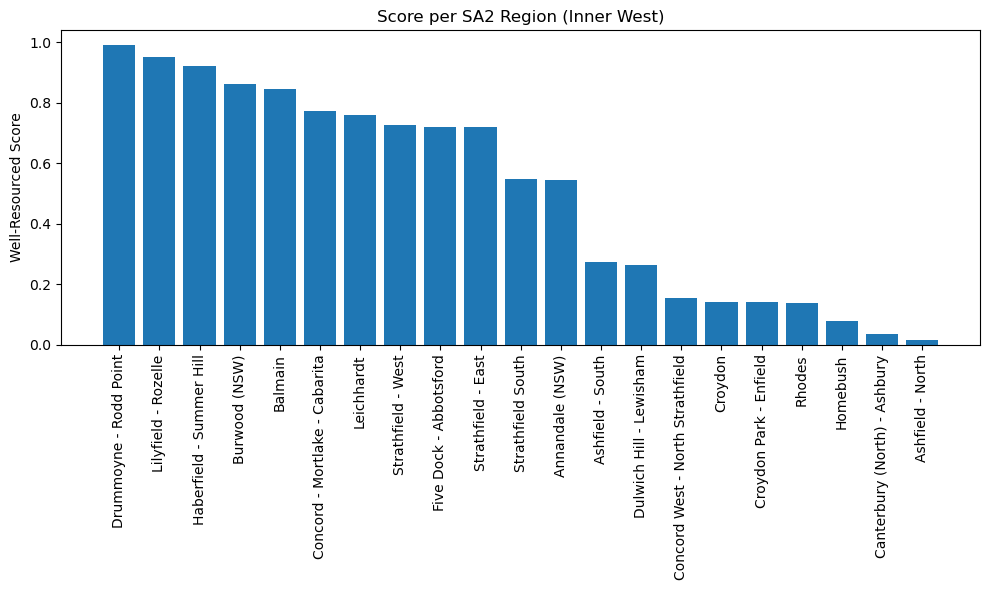

In [50]:

df_sorted = score.sort_values("score", ascending=False)
plt.figure(figsize=(10,6))
plt.bar(df_sorted["sa2_name"], df_sorted["score"])
plt.xticks(rotation=90)
plt.ylabel("Well-Resourced Score")
plt.title("Score per SA2 Region (Inner West)")
plt.tight_layout()
plt.show()


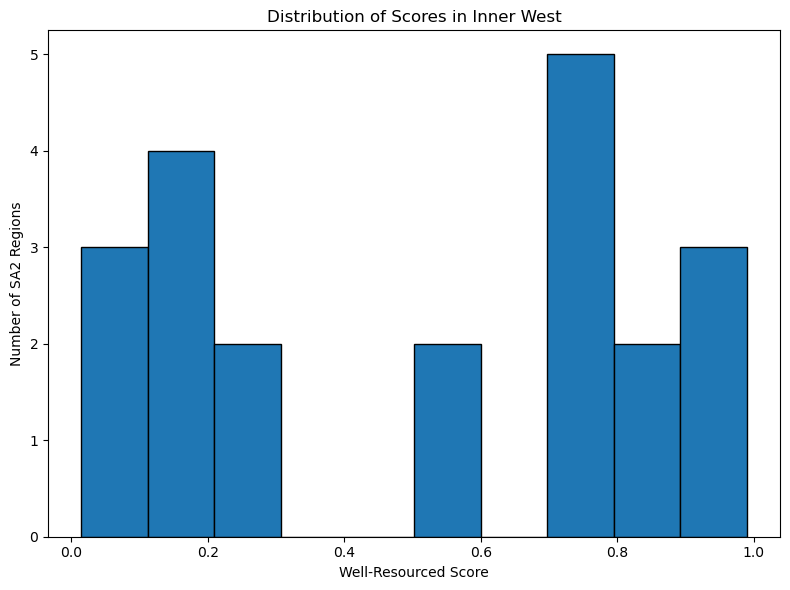

In [51]:
plt.figure(figsize=(8, 6))
plt.hist(score["score"], bins=10, edgecolor='black')
plt.xlabel("Well-Resourced Score")
plt.ylabel("Number of SA2 Regions")
plt.title("Distribution of Scores in Inner West")
plt.tight_layout()
plt.show()

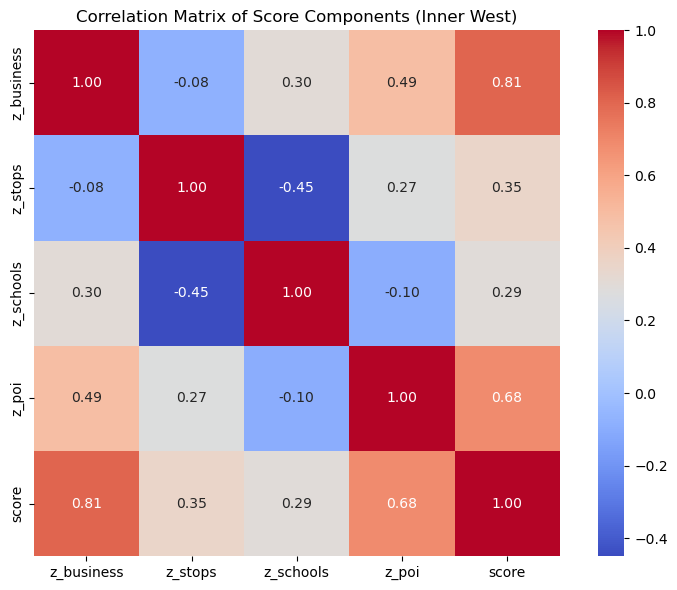

In [52]:
corr_matrix=score[["z_business", "z_stops", "z_schools", "z_poi", "score"]].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", square=True)
plt.title("Correlation Matrix of Score Components (Inner West)")
plt.tight_layout()
plt.show()

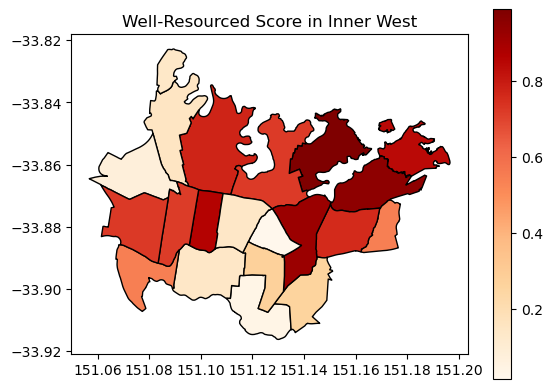

In [53]:
sa2_inner_west.to_file("inner_west_sa2.geojson", driver="GeoJSON")
gdf = gpd.read_file("inner_west_sa2.geojson")
gdf["SA2_CODE21"] = gdf["SA2_CODE21"].astype(int)
gdf = gdf.merge(score, left_on="SA2_CODE21", right_on="sa2_code")

gdf.plot(column="score", cmap="OrRd", legend=True, edgecolor="black")
plt.title("Well-Resourced Score in Inner West")
plt.show()

In [54]:
merged = score.merge(income, left_on="sa2_code", right_on="sa2_code21")
merged[["score", "median_income"]].corr()

,score,median_income
score,1.000000,0.463252
median_income,0.463252,1.000000


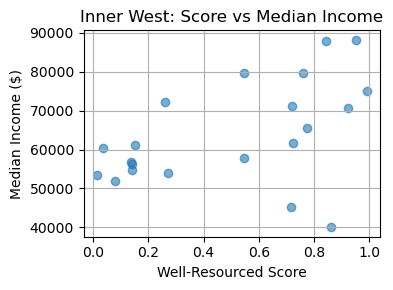

In [128]:
merged["median_income"] = pd.to_numeric(merged["median_income"], errors="coerce")

plt.figure(figsize=(4, 3))
plt.scatter(merged["score"], merged["median_income"], alpha=0.6)
plt.xlabel("Well-Resourced Score")
plt.ylabel("Median Income ($)")
plt.title("Inner West: Score vs Median Income")
plt.grid(True)
plt.tight_layout()
plt.show()